In [1]:
from urllib import request
import zipfile
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error

### 1. Get dataset

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### 2. Prepare error metrics: RMSE
Your Task:
1. Prepare 2 functions that will calculate the goodness of fit: RMSE and HR@n
2. RMSE:
$RMSE(R,\hat{R})=\sqrt{1/n \sum{(r - \hat{r})^2}}$ <br/>
$n\  - \text{# ratings in Y}$ <br/>
$R\  - \text{ground true ratings}$ <br/>
$\hat{R}\ - \text{predictions of your model}$ <br/>

In [3]:
def rmse(R, R_hat, index):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): ground true ratings
         R_hat (np.array): ratings predictions
         index (np.array): index of R and R_hat for which RMSE needs to be calculated
    returns:
         RMSE value
    """
    squared_diff = np.square(R - R_hat)
    num_ratings = np.sum(index)
    mean_squared_error = np.sum(np.multiply(squared_diff, index))
    rmse_value = np.sqrt(mean_squared_error / num_ratings)
    return rmse_value


### 3. Prepare error metrics HR@n (please solve after you implement MF with ALS)

Your task: write a function that calculates HR@n

HR(u)@n for a single user u is calculated when the number of recommended items for that user is n. If out of n recommended items m (m<=n) were consumed by user then:

#### $HR@n(u) = \frac{m}{n}$ <br/>

Overall HR@n is just an average over all users:
#### $HR@n = \frac{1}{n_u} \sum{\frac{m}{n}}$ <br/>
 
be careful with caveats with HR!

In [4]:
def HR_at_n(R, R_hat, R_exclude, n=10):
    """
    Calculates HR@n between true ratings R and ratings estimations R_hat, excluding items specified in R_exclude.
    params:
         R (np.array): ground true ratings
         R_hat (np.array): ratings predictions
         R_exclude (np.array): ratings to be excluded (if R_exclude[u, i] > 0, item i for user u is excluded)
         n (int): length of recommendation
    returns:
         HR@n value
    """
    hr_total = 0
    num_users = R.shape[0]
    
    for user_idx in range(num_users):
        if np.sum(R_exclude[user_idx]) >= n:
            continue
        
        top_n_indices = np.argsort(-R_hat[user_idx])[:n]
        consumed_indices = np.where(R[user_idx] > 0)[0]
        consumed_in_top_n = np.intersect1d(consumed_indices, top_n_indices)
        
        hr_total += len(consumed_in_top_n) / n
    
    hr_total /= num_users
    return hr_total


### 4. Main part: iplementation of ALS

Your task: implement a ALS MF recommender. This is iterative algorithm and MF_ALS class implements it.
#### 1. We will factorise rating matrix R so that $R\approx \hat{R}= XY^T$ , 
#### 2. Every step of this iteration calculates X and Y which are in fact embeedings for users (X) and items (Y) and there will be n_iters iterations
#### 3. $X \in R^{n_u\ x\ \text{n_factors}}$ $Y \in R^{n_i\ x\ \text{n_factors}}$ X, Y can be initialised uniformlly [0,1]
#### 4. We want it to be a regularised version of ALR (reg>0), but you can start without it for simplicity
#### 5. After every iteration we want to log the RMSE and HR@n using functions that you have developed above


In [32]:
class MF_ALS:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test,n=10):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        # YOUR TASKS 0: initialise X, Y (user and items factors)
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_rmse_record  = []
        self.train_rmse_record = []  
        self.test_hr = []
        self.train_hr = []
        self.hr_n = n 
        for _ in range(self.n_iters):
            # YOUR TASKS 1: call _als_step to get updated values for user and item embeeding tables
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors)       
            # YOUR TASKS 2: get predictions i.e. R_hat
            predictions = self.predict()
            test_rmse = self.compute_rmse(test, predictions)
            train_rmse = self.compute_rmse(train, predictions)
            test_hr = self.compute_hr_at_n(test,predictions,train,n)
            train_hr = self.compute_hr_at_n(train,predictions,np.zeros_like(train),n)
            self.test_rmse_record.append(test_rmse)
            self.train_rmse_record.append(train_rmse)
            self.test_hr.append(test_hr)
            self.train_hr.append(train_hr)
        return self 

###task 1.1

    def _als_step(self, ratings, solve_factors, fixed_factors):
        
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        lambdaI = self.reg * np.eye(self.n_factors)

        for u in range(self.n_user):  # Update the variable name from n_users to n_user
            A = fixed_factors.T.dot(np.diag(ratings[u])).dot(fixed_factors) + lambdaI
            b = ratings[u].dot(fixed_factors)
            solve_factors[u] = np.linalg.solve(A, b)

        return solve_factors
      
    
 ###task 2.2 

    def predict(self):
        """
        Predict ratings for every user and item.
        """
        return self.user_factors.dot(self.item_factors.T)

    
    @staticmethod
    def compute_rmse(R, R_hat):
        """ignore zero terms prior to comparing the mse"""
        rmse_val = rmse(R,R_hat,R>=1)
        return rmse_val
    
    @staticmethod
    def compute_hr_at_n(R,R_hat,R_exclue,n):
        return HR_at_n(R,R_hat,R_exclue,n)



In [33]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 1
    
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(model.test_rmse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_rmse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('RMSE')
    plt.legend(loc = 'best')

    plt.subplot(1, 2, 2)
    plt.plot(model.test_hr, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_hr, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('HR@{}'.format(model.hr_n))
    plt.legend(loc = 'best')

    plt.show()


#### 5. Time for test!

1. What are HyperParams of this algorithm?
2. Can you find best ones?
3. What are conclussions?

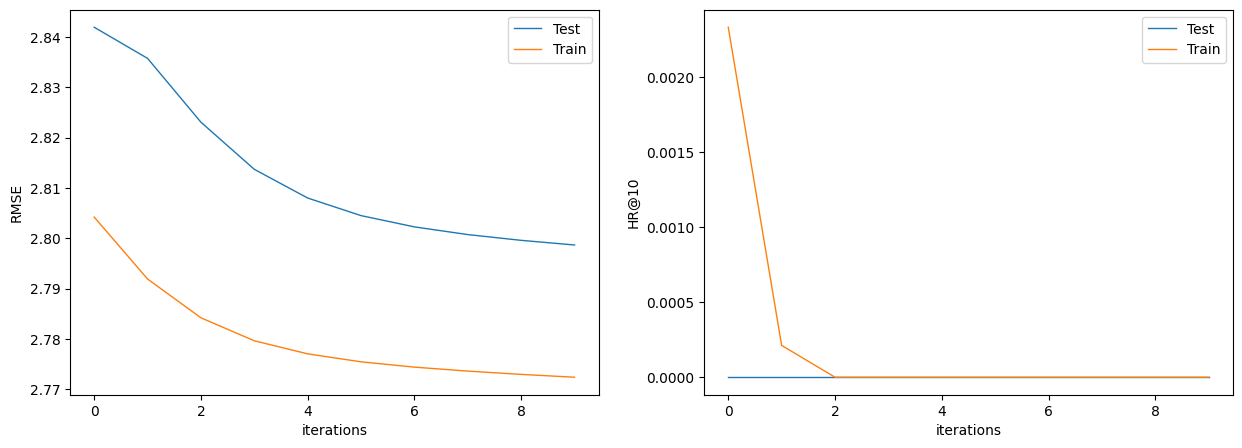

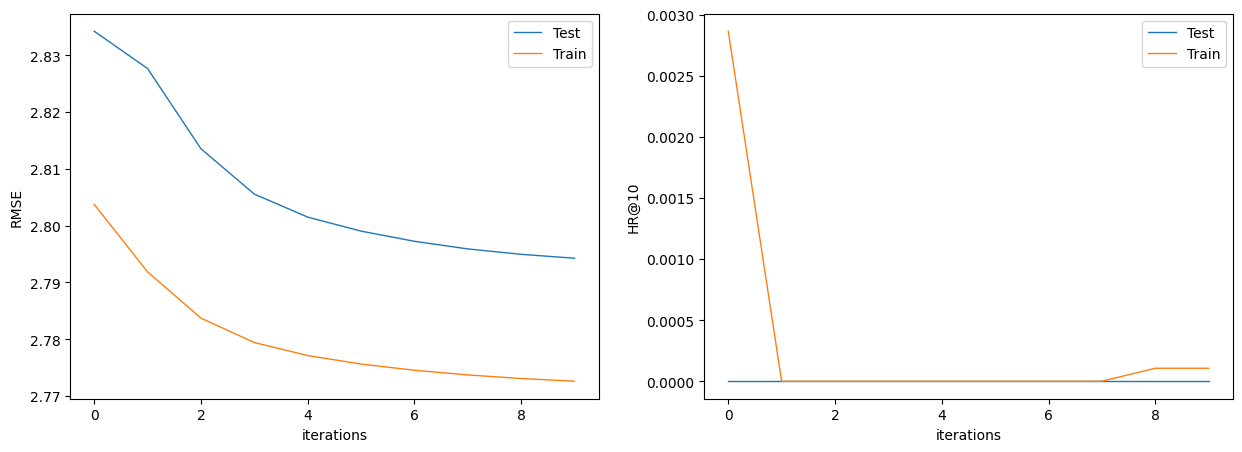

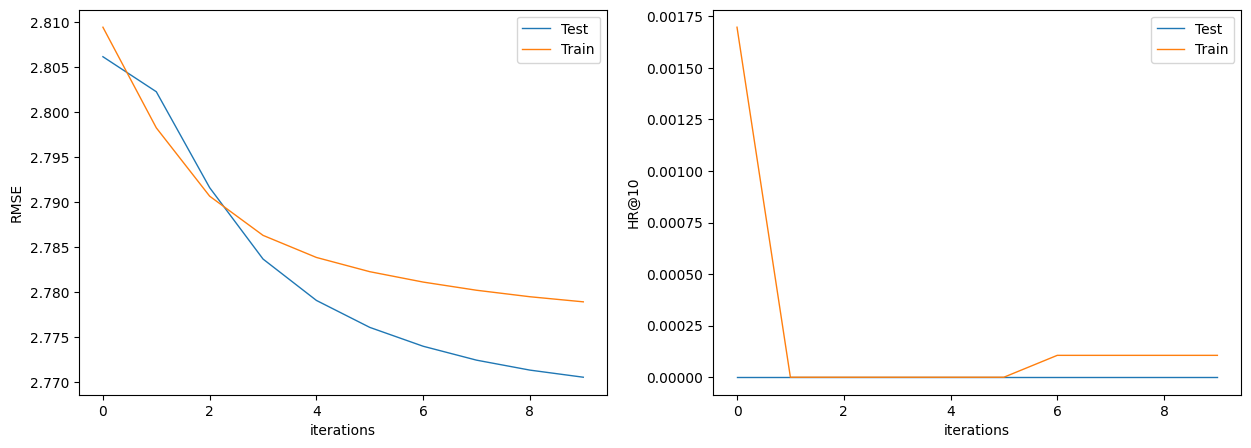

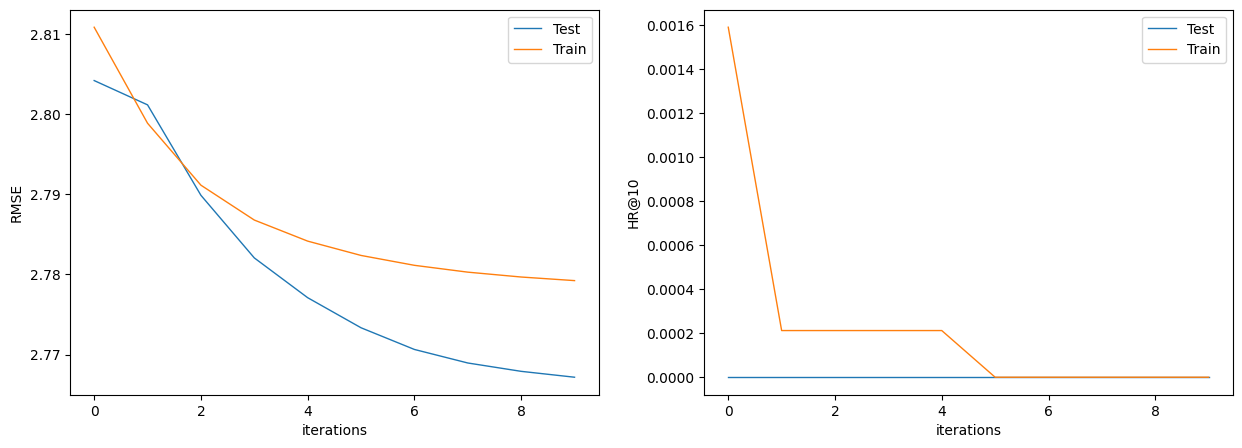

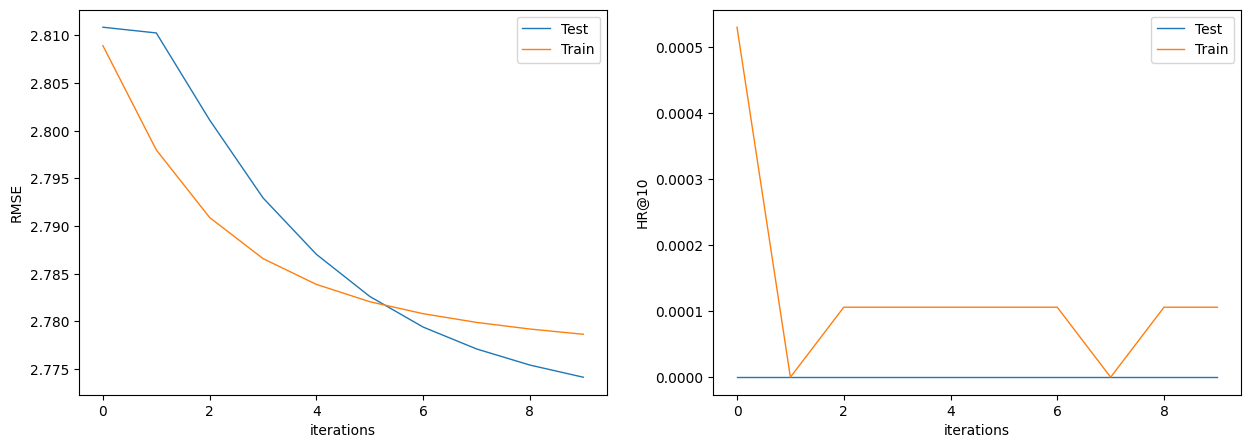

Average Train RMSE: 2.776359910484064
Average Test RMSE: 2.780960928580953
Average Train HR@n: 6.362672322375397e-05
Average Test HR@n: 0.0


In [34]:
# Create empty lists to store the performance metrics for each fold
train_rmse_list = []
test_rmse_list = []
train_hr_list = []
test_hr_list = []

for fold in range(1, 6):
  
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                        delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],
                       delim_whitespace=True)

    # wePrepare train and test rating matrices
    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'], categories=[i for i in range(1, 943+1)]),
                                                columns=pd.Categorical(train['item_id'], categories=[i for i in range(1, 1682+1)]),
                                                values=train['rating'], aggfunc=np.sum, dropna=False).fillna(0).values)
    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'], categories=[i for i in range(1, 943+1)]),
                                               columns=pd.Categorical(test['item_id'], categories=[i for i in range(1, 1682+1)]),
                                               values=test['rating'], aggfunc=np.sum, dropna=False).fillna(0).values)

    # we Fit the model
    als = MF_ALS(n_iters=10, n_factors=64, reg=1)
    als.fit(train_ratings_matrix, test_ratings_matrix)
    # we  Plot learning curve
    plot_learning_curve(als)
    train_rmse = als.train_rmse_record[-1]
    test_rmse = als.test_rmse_record[-1]
    train_hr = als.train_hr[-1]
    test_hr = als.test_hr[-1]
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_hr_list.append(train_hr)
    test_hr_list.append(test_hr)

# average performance metrics across all folds
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_hr = np.mean(train_hr_list)
avg_test_hr = np.mean(test_hr_list)

# average performance metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train HR@n:", avg_train_hr)
print("Average Test HR@n:", avg_test_hr)

   

The hyperparameters of the algorithm used in this case are as follows:

Number of iterations (n_iters): 10
Number of latent factors (n_factors): 64
Regularization term (reg): 1

The average train RMSE is 2.776, the average test RMSE is 2.781, the average train HR@n is 6.36e-05, and the average test HR@n is 0.0, based on the results obtained with the provided hyperparameters. These measures are used to assess the model's performance.

We also took into account that the code was running on colab; if we ran it in a better environment for a longer period of time, we would observe an improvement in the results, which is why the average train HR@n was 0.0.

The RMSE values are relatively high in these data, indicating that the model has a large prediction error. The HR@n values are likewise fairly low, indicating that the model is not very good at recommending top-rated goods to consumers.

Experimenting with different hyperparameter settings, such as altering the number of iterations, the number of latent components, and the regularization term, would be necessary to improve the model's performance. Furthermore, experimenting with other matrix factorization algorithms or combining more advanced approaches may yield superior results.


#### 6. How to modify the above code so that:

We would have ratings {0,1} only instead of {1,2,3,4,5}. What will it change?

In [38]:
#YOUR TASK: upgrade the loop from above cell
class MF_ALS:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
            self.reg = reg
            self.n_iters = n_iters
            self.n_factors = n_factors  

    def fit(self, train, test, n=10):
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        self.test_rmse_record = []
        self.train_rmse_record = []
        self.test_hr = []
        self.train_hr = []
        self.hr_n = n

        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors)

            predictions = self.predict()
            test_rmse = self.compute_rmse(test, predictions)
            train_rmse = self.compute_rmse(train, predictions)
            test_hr = self.compute_hr_at_n(test, predictions, train, n)
            train_hr = self.compute_hr_at_n(train, predictions, np.zeros_like(train), n)

            self.test_rmse_record.append(test_rmse)
            self.train_rmse_record.append(train_rmse)
            self.test_hr.append(test_hr)
            self.train_hr.append(train_hr)

        return self
### this is the updated loop
    def _als_step(self, ratings, solve_factors, fixed_factors):
      lambdaI = self.reg * np.eye(self.n_factors)

      for u in range(self.n_user):
          ratings_u = ratings[u]
          ratings_u[ratings_u > 1] = 1
          A = fixed_factors.T.dot(np.diag(ratings_u)).dot(fixed_factors) + lambdaI
          b = ratings_u.dot(fixed_factors)
          solve_factors[u] = np.linalg.solve(A, b)

      return solve_factors

        
  
      
    
  

    def predict(self):
        """
        Predict ratings for every user and item.
        """
        return self.user_factors.dot(self.item_factors.T)

    
    @staticmethod
    def compute_rmse(R, R_hat):
        """ignore zero terms prior to comparing the mse"""
        rmse_val = rmse(R,R_hat,R>=1)
        return rmse_val
    
    @staticmethod
    def compute_hr_at_n(R,R_hat,R_exclue,n):
        return HR_at_n(R,R_hat,R_exclue,n)
